In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import geopandas as gp

import nltk
from nltk.tokenize import word_tokenize

# nltk.download('wordnet')

## Cargamos los datos

In [2]:
path = r'C:\Users\javie\OneDrive\Documentos\Javier\Pega\freelance\Gregario\homologacion'
raw_file = r'datos_scrapeados_procesados_disponibles.xlsx'
# processed_file = r'datos_usados_homologacion_actual.xlsx'
raw_path = os.path.join(path, raw_file)
# processed_path = os.path.join(path, processed_file)

raw_data = pd.read_excel(raw_path, index_col=0)
# processed_data = pd.read_excel(processed_path, index_col=0)

### Observamos un resumen

In [4]:
# processed_data.head(2)

In [3]:
raw_data.head(2)

,id,scraper_source,code,name,company_name,store_category,street,city,locality,region,...,food_rating,speed_rating,service_rating,schedule,review_count,store_since,min_insert_date,max_insert_date,url,load_date
0,1031886,Rappi,900067897,Sushi House Los Pioneros,NaN,Sushi Pollo,"Los Pioneros 1851, Temuco, Araucanía, Chile",NaN,NaN,NaN,...,NaN,NaN,NaN,"open_time: 13:00:00, close_time: 22:15:00",0.0,NaN,2022-01-19,2022-05-11,NaN,2022-05-11
1,1031887,Rappi,900020706,Contento,NaN,Asiática,"Gral. Manuel Baquedano 834, Antofagasta, Regió...",NaN,NaN,NaN,...,NaN,NaN,NaN,"open_time: 12:00:00, close_time: 20:00:00",142.0,NaN,2021-11-24,2022-08-08,NaN,2022-08-08


In [4]:
print(raw_data.shape)
# print(processed_data.shape)

(46386, 28)


### Creamos nuestro set de datos a partir de los datos crudos

In [5]:
selected_data = raw_data.loc[:,['scraper_source','name','street','latitude','longitude','code']]

### Convertimos algunas columnas data type: "categoría", y verificamos la cantidad

In [6]:
selected_data.loc[:,'scraper_source'] = selected_data.loc[:,'scraper_source'].astype('category')

<AxesSubplot:>

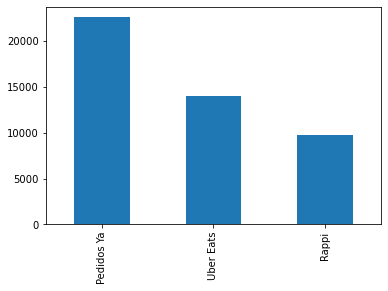

In [7]:
selected_data.loc[:,'scraper_source'].value_counts().plot.bar()

In [8]:
def count_null(df):

    return selected_data.isna().sum()

def count_duplicated(series):
    
    return series.duplicated().sum()

In [9]:
print(count_duplicated(selected_data['code']))
count_null(selected_data)

0


scraper_source      0
name                0
street            213
latitude            0
longitude           0
code                0
dtype: int64

## Cargamos las comunas en formatos SHP (Formato de "shapes" para trabajar con mapas)

In [10]:
path_comunas = r'C:\Users\javie\OneDrive\Documentos\Javier\Pega\freelance\Gregario\homologacion'
comunas_file = r'comunas.shp'
comunas_path = os.path.join(path_comunas,comunas_file)

comunas_df = gp.read_file(comunas_path)
comunas_df = comunas_df.loc[:,['Region','Comuna','geometry']]
comunas_df.set_geometry(col='geometry', inplace='True')
comunas_df = comunas_df.to_crs('epsg:4326')

AttributeError: module 'geopandas' has no attribute 'read_file'

### Vemos un resumen

In [13]:
comunas_df.head(2)

,Region,Comuna,geometry
0,Región del Libertador Bernardo O'Higgins,Marchigüe,"POLYGON ((-71.80071 -34.20728, -71.79992 -34.2..."
1,Región del Libertador Bernardo O'Higgins,Codegua,"POLYGON ((-70.35293 -33.95263, -70.35243 -33.9..."


## Transformaremos a los dataframes en Geo Dataframes, para poder trabajar con las comunas (obtenidas desde el archivo .SHP)

In [1]:
def to_geopandas(df, crs):
    gdf = gp.GeoDataFrame(
    df, geometry=gp.points_from_xy(x=df.longitude, y=df.latitude, crs=crs)
)   
    gdf = gdf.drop(['latitude','longitude'], axis=1)
    return gdf

In [15]:
pedidos_df = selected_data.loc[selected_data['scraper_source']=='Pedidos Ya']
pedidos_gdf = to_geopandas(pedidos_df, 'epsg:4326')
pedidos_gdf.set_geometry(col='geometry', inplace=True)

uber_df = selected_data.loc[selected_data['scraper_source']=='Uber Eats']
uber_gdf = to_geopandas(uber_df, 'epsg:4326')
uber_gdf.set_geometry(col='geometry', inplace=True)

rappi_df = selected_data.loc[selected_data['scraper_source']=='Rappi']
rappi_gdf = to_geopandas(rappi_df, 'epsg:4326')
rappi_gdf.set_geometry(col='geometry', inplace=True)

In [16]:
count_null(pedidos_df)

scraper_source      0
name                0
street            213
latitude            0
longitude           0
code                0
dtype: int64

In [17]:
count_null(uber_gdf)

scraper_source      0
name                0
street            213
latitude            0
longitude           0
code                0
dtype: int64

In [18]:
count_null(rappi_gdf)

scraper_source      0
name                0
street            213
latitude            0
longitude           0
code                0
dtype: int64

## Corroboramos que todos los datos estén el mismo plano de proyecciones geográficas:

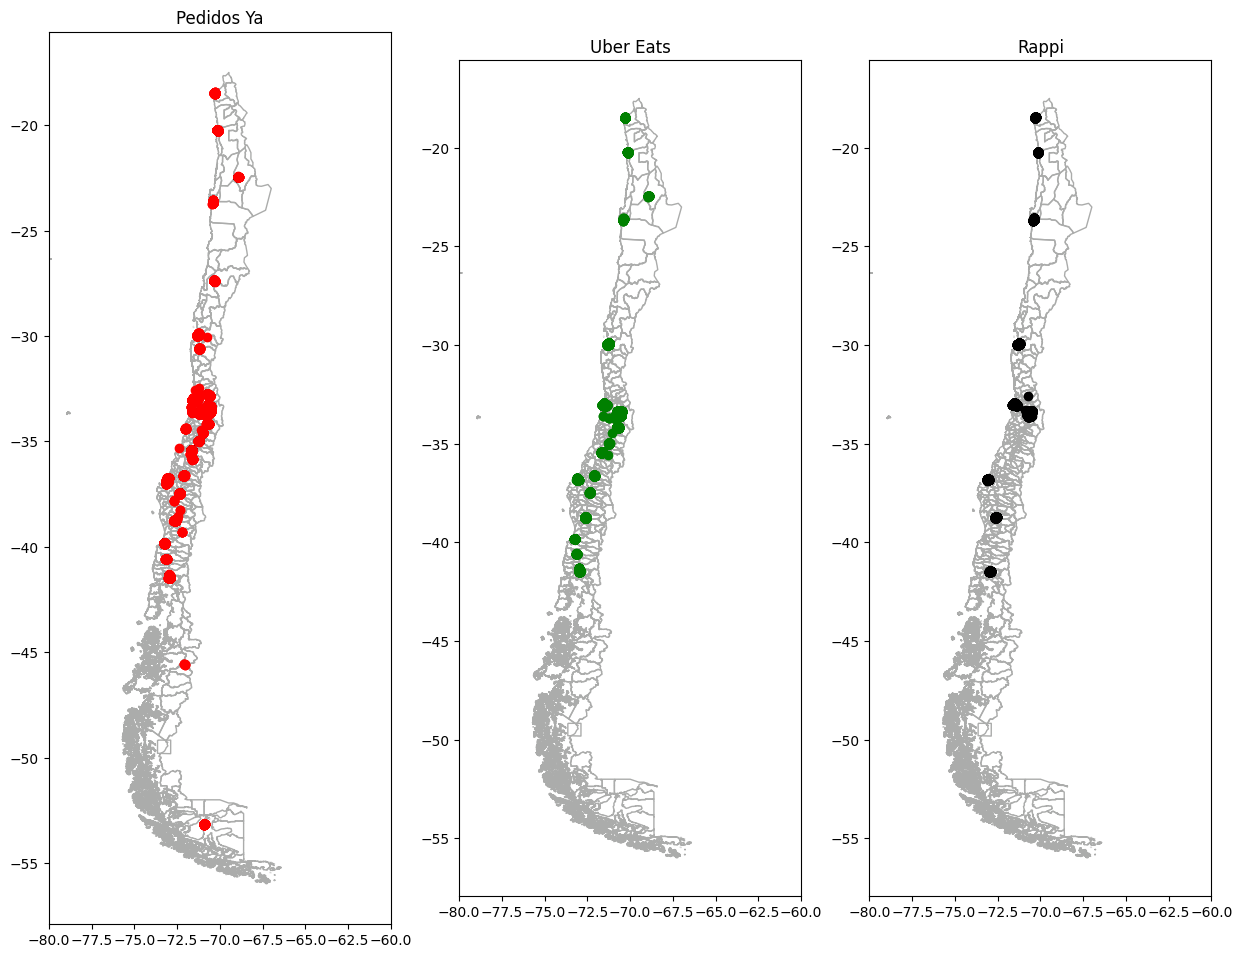

In [19]:
dfs = [pedidos_gdf, uber_gdf, rappi_gdf]
nombres = ['Pedidos Ya', 'Uber Eats', 'Rappi']

def plot_locals_and_maps(gdfs_list):

    DFS_LEN = len(gdfs_list)
    COLORS = ['r', 'green', 'black']
    fig, axes = plt.subplots(1, DFS_LEN, figsize=(15,12))

    for (gdf, axe, color, nombre) in zip(gdfs_list, axes.flatten(), COLORS, nombres):
        comunas_df.plot(facecolor='none', edgecolor="#abacab", linewidth=1, ax=axe)
        gdf.plot(color=color, ax=axe)
        axe.set_xlim(-80,-60)
        axe.set_title(nombre)
    plt.show()

plot_locals_and_maps(dfs)

# Aquí comienzo nuevo enfoque

## Realizamos el procesamiento de datos de lenguaje natural

In [5]:
def preprocess_string_columns(df, columnas_a_procesar):

    """ Realiza el procesamiento de los datos tipo texto: ejecutando un tokenizador de palabras,
        eliminando palabras innecesarias, y por último deja todos los tokens en minúscula.
        
        Recibe: 
            - Un data frame que debe contener columnas con datos tipo "string" que deseemos procesar.
            - Una "lista" con los nombres de las columnas que queremos procesar, en formato "string".
        Retorna:
            - El dataframe original, con las columnas de texto ya procesadas. """
        

    def preprocess_string_series(series):
        """ Realiza el procesamiento antes mencionado, pero de manera individual, por lo que recibe
            solo una columna. """

        stop_punkt = ['.', ',', '-', '´', '\'', 'la', 'el', 'los', 'y', 'o', 'e', 'a', 'de', 'del', '!', '¡', '?', '¿', 'tu', 'tú', 'mi', 'mí',
                        'av', 'avenida', 'calle']
        tokens = word_tokenize(series)
        
        return [w for w in tokens if w not in stop_punkt]


    for columna in columnas_a_procesar:
        df[columna] = df[columna].apply(lambda x: str(x).lower())
        df[columna] = df.apply(lambda row: preprocess_string_series(row[columna]), axis=1)

    return df

Ejecutamos la función anterior  en nuestro dataframe, y elegimos las columnas "name", y "street" que contienen los datos tipo texto que queremos procesar:

In [21]:
columnas = ['name', 'street']

pedidos_gdf = preprocess_string_columns(pedidos_gdf, columnas)
uber_gdf = preprocess_string_columns(uber_gdf, columnas)
rappi_gdf = preprocess_string_columns(rappi_gdf, columnas)

In [7]:
columnas = ['name', 'street']
selected_processed = preprocess_string_columns(selected_data, columnas)

In [8]:
selected_processed

,scraper_source,name,street,latitude,longitude,code
0,Rappi,"[sushi, house, pioneros]","[pioneros, 1851, temuco, araucanía, chile]",-38.754190,-72.632833,900067897
1,Rappi,[contento],"[gral, manuel, baquedano, 834, antofagasta, re...",-23.651406,-70.395670,900020706
2,Rappi,"[bread, factory]","[irarrazaval, 3790]",-33.455312,-70.590159,900022369
3,Rappi,"[joys, chicken]","[playa, brava, 2016, iquique, tarapacá, chile]",-20.242246,-70.141202,900067708
4,Rappi,"[pizza, teo, valparaiso]","[rancagua, 174, valparaíso, chile]",-33.050344,-71.605024,900078970
...,...,...,...,...,...,...
46381,Rappi,"[deli, café]","[gabriela, mistral2759, serena]",-29.930823,-71.246679,900065086
46382,Rappi,"[sayonara, sushi, peñalolen]","[tobalaba, 14125, peñalolén, chile]",-33.506451,-70.561021,900020902
46383,Rappi,"[maki, sushi, puerto, montt]","[sargento, silva, 171]",-41.460807,-72.939779,900048951
46384,Rappi,"[sushi, blues, mall, plaza, egaña]","[larrain, 5862, l., 4020, reina]",-33.452438,-70.569470,900017210


In [9]:
selected_processed['a_comparar'] = selected_processed['name'] + selected_processed['street']

In [10]:
selected_processed#.set_index('code')['a_comparar']

,scraper_source,name,street,latitude,longitude,code,a_comparar
0,Rappi,"[sushi, house, pioneros]","[pioneros, 1851, temuco, araucanía, chile]",-38.754190,-72.632833,900067897,"[sushi, house, pioneros, pioneros, 1851, temuc..."
1,Rappi,[contento],"[gral, manuel, baquedano, 834, antofagasta, re...",-23.651406,-70.395670,900020706,"[contento, gral, manuel, baquedano, 834, antof..."
2,Rappi,"[bread, factory]","[irarrazaval, 3790]",-33.455312,-70.590159,900022369,"[bread, factory, irarrazaval, 3790]"
3,Rappi,"[joys, chicken]","[playa, brava, 2016, iquique, tarapacá, chile]",-20.242246,-70.141202,900067708,"[joys, chicken, playa, brava, 2016, iquique, t..."
4,Rappi,"[pizza, teo, valparaiso]","[rancagua, 174, valparaíso, chile]",-33.050344,-71.605024,900078970,"[pizza, teo, valparaiso, rancagua, 174, valpar..."
...,...,...,...,...,...,...,...
46381,Rappi,"[deli, café]","[gabriela, mistral2759, serena]",-29.930823,-71.246679,900065086,"[deli, café, gabriela, mistral2759, serena]"
46382,Rappi,"[sayonara, sushi, peñalolen]","[tobalaba, 14125, peñalolén, chile]",-33.506451,-70.561021,900020902,"[sayonara, sushi, peñalolen, tobalaba, 14125, ..."
46383,Rappi,"[maki, sushi, puerto, montt]","[sargento, silva, 171]",-41.460807,-72.939779,900048951,"[maki, sushi, puerto, montt, sargento, silva, ..."
46384,Rappi,"[sushi, blues, mall, plaza, egaña]","[larrain, 5862, l., 4020, reina]",-33.452438,-70.569470,900017210,"[sushi, blues, mall, plaza, egaña, larrain, 58..."


In [207]:
def comparacion_de_locales(df, columna, umbral):

    def jaccard_similarity(list1, list2):
        """ Calcula la similitud Jaccard entre dos listas de tokens.
            Recibe:
                - Dos listas con tokens
            Retorna:
                - La similitud Jaccard entre dichas listas """

        s1 = set(list1)
        s2 = set(list2)

        return float(len(s1.intersection(s2)) / len(s1.union(s2)))

    # locales = dict(zip(df['code'], df[columna]))

    def comparador(valor):
        matches = df.apply(lambda row: jaccard_similarity(row['a_comparar'], valor), axis=1)
        return matches#[matches>umbral]

    # for key in locales:
    df_jacc = df.apply(lambda row: comparador(row[columna]), axis=1)

    return df_jacc

In [46]:
from tqdm import tqdm

In [53]:
# Se tarda 1 hora y 40, sin embargo puede mejorar

#  def jaccard_similarity(list1, list2):
#     """ Calcula la similitud Jaccard entre dos listas de tokens.
#         Recibe:
#             - Dos listas con tokens
#         Retorna:
#             - La similitud Jaccard entre dichas listas """

#     s1 = set(list1)
#     s2 = set(list2)

#     return float(len(s1.intersection(s2)) / len(s1.union(s2)))

# df = selected_processed#.iloc[:2000,:]
# locales = dict(zip(df['code'], df['a_comparar']))
# # locales_2 = dict(zip(df.index, df['a_comparar']))

# clusters = {}#pd.DataFrame(columns=['cluster', 'miembros'])
# umbral = 0.5
# columna = 'a_comparar'
# visited_ids = []
# for key in tqdm(locales, total=len(locales)):
#     if key in visited_ids:
#         continue
#     else:
#         df['jac_sim'] = df.loc[:,'a_comparar'].apply(lambda row: jaccard_similarity(row, locales[key]))
#         # clusters.append(key,df[df['jac_sim']>umbral]['code'].tolist())
#         clusters[key] = clusters.get(key, [])
#         matches = df[df['jac_sim']>umbral]['code'].tolist()
#         clusters[key].append(matches)
#         visited_ids.append(matches)
        
# # salida = df[df['jac_sim']>umbral]

100%|██████████| 46386/46386 [1:48:57<00:00,  7.10it/s]  


In [62]:
clusters['5a07c03d-87cc-5036-bea7-3a46ca54e9e3']

[['5a07c03d-87cc-5036-bea7-3a46ca54e9e3']]

In [64]:
clusters_df = pd.DataFrame.from_dict(clusters, orient='index').stack()

In [65]:
clusters_df

900067897  0                               [900067897, 900067870]
900020706  0    [900020706, bf973f2a-f193-4f2c-b93f-fbf7098a7927]
900022369  0    [900022369, b9b93288-e207-4542-a834-5e8290b5f2fb]
900067708  0                               [900067708, 900067691]
900078970  0    [900078970, e61f86e1-adf0-533b-ae4a-9f1f2081c9...
                                      ...                        
900065086  0                                          [900065086]
900020902  0    [d61d5c97-ee1f-45e1-84bc-83f07652db81, 116723,...
900048951  0                       [166753, 900072892, 900048951]
900017210  0                       [111691, 900016080, 900017210]
900067212  0    [900064832, aa4a2426-3c05-4cd9-be24-48bbfacfb8...
Length: 46386, dtype: object

In [66]:
clusters_df.to_excel('Clusters_locales(v1).xlsx')

In [97]:
def jaccard_similarity(list1, list2):
    """ Calcula la similitud Jaccard entre dos listas de tokens.
        Recibe:
            - Dos listas con tokens
        Retorna:
            - La similitud Jaccard entre dichas listas """

    s1 = set(list1)
    s2 = set(list2)

    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

df = selected_processed#.iloc[:2000,:]
locales = dict(zip(df['code'], df['a_comparar']))


clusters = {}
umbral = 0.5
columna = 'a_comparar'
visited_ids = []
for value, key in enumerate(locales):
    print(key)
    if key in visited_ids:
        continue
    else:
        df['jac_sim'] = df.loc[:,'a_comparar'].apply(lambda row: jaccard_similarity(row, locales[key]))
        clusters[key] = clusters.get(key, [])
        matches = df[df['jac_sim']>umbral]['code'].tolist()
        clusters[key].append(matches)
        locales.pop(key)
        # locales= [loc for loc in locales if loc not in matches]

900067897


RuntimeError: dictionary changed size during iteration

In [92]:
df.loc[:,'a_comparar']

0        [sushi, house, pioneros, pioneros, 1851, temuc...
1        [contento, gral, manuel, baquedano, 834, antof...
2                      [bread, factory, irarrazaval, 3790]
3        [joys, chicken, playa, brava, 2016, iquique, t...
4        [pizza, teo, valparaiso, rancagua, 174, valpar...
                               ...                        
46381          [deli, café, gabriela, mistral2759, serena]
46382    [sayonara, sushi, peñalolen, tobalaba, 14125, ...
46383    [maki, sushi, puerto, montt, sargento, silva, ...
46384    [sushi, blues, mall, plaza, egaña, larrain, 58...
46385    [pad, thai, house, manquehue, sur, 1231, las, ...
Name: a_comparar, Length: 46386, dtype: object

In [89]:
locales

['900020706',
 '900022369',
 '900067708',
 '900078970',
 '900067825',
 '900073804',
 '900029286',
 '900048395',
 '900040576',
 '900024686',
 '900079167',
 '900071486',
 '900029934',
 '900048826',
 '900040503',
 '900072851',
 '900022857',
 '900075343',
 '900079249',
 '900022508',
 '900048414',
 '900018319',
 '900067647',
 '900067395',
 '900075524',
 '900079213',
 '900026427',
 '900077716',
 '900069210',
 '900019411',
 '900018336',
 '900056714',
 '900032291',
 '900021010',
 '900073021',
 '900015979',
 '900075666',
 '900069363',
 '900022881',
 '900029911',
 '900073541',
 '900031465',
 '900018648',
 '900057391',
 '900036655',
 '900069022',
 '900030045',
 '900023585',
 '900041408',
 '900021151',
 '900020624',
 '900040138',
 '900077725',
 '900071601',
 '900014829',
 '900023405',
 '900023314',
 '900020240',
 '900040511',
 '900068682',
 '900018299',
 '900079374',
 '900032813',
 '900069993',
 '900069169',
 '900018607',
 '900026009',
 '900078451',
 '900075533',
 '900025392',
 '900048692',
 '9000

In [306]:
# Tarda dos (2) horas

# def jaccard_similarity(list1, list2):
#     """ Calcula la similitud Jaccard entre dos listas de tokens.
#         Recibe:
#             - Dos listas con tokens
#         Retorna:
#             - La similitud Jaccard entre dichas listas """

#     s1 = set(list1)
#     s2 = set(list2)

#     return float(len(s1.intersection(s2)) / len(s1.union(s2)))

# df = selected_processed.iloc[:2000,:]
# locales_1 = dict(zip(df.index, df['a_comparar']))
# locales_2 = dict(zip(df.index, df['a_comparar']))

# clusters = {}
# umbral = 0.5
# for key_1 in locales_1:
#     for key_2 in locales_2:
#         jac_sim = jaccard_similarity(locales_1[key_1], locales_2[key_2])
#         if jac_sim > umbral:
#             clusters[key_1] = clusters.get(key_1, [])
#             clusters[key_1].append(key_2)

KeyboardInterrupt: 

In [ ]:
# Tarda Mucho

# def jaccard_similarity(list1, list2):
#     """ Calcula la similitud Jaccard entre dos listas de tokens.
#         Recibe:
#             - Dos listas con tokens
#         Retorna:
#             - La similitud Jaccard entre dichas listas """

#     s1 = set(list1)
#     s2 = set(list2)

#     return float(len(s1.intersection(s2)) / len(s1.union(s2)))

# df = selected_processed#.iloc[:2000,:]
# locales_1 = dict(zip(df.index, df['a_comparar']))
# locales_2 = dict(zip(df.index, df['a_comparar']))

# clusters = {}
# umbral = 0.5
# used_keys_2 = []
# for key_1 in locales_1:
#     for key_2 in locales_2:
#         if (key_1 == key_2) | (key_2 in used_keys_2):
#             continue
#         else:
#             jac_sim = jaccard_similarity(locales_1[key_1], locales_2[key_2]) 
#             if jac_sim > umbral:
#                 clusters[key_1] = clusters.get(key_1, [])
#                 clusters[key_1].append(key_2)
#                 used_keys_2.append(key_2)

In [305]:
clusters

{'900067897': ['900067870'],
 '900048395': ['900048496'],
 '900024686': ['900024849'],
 '900079213': ['900075711'],
 '900056714': ['900048142'],
 '900069363': ['050bfb5a-6935-51b8-b52a-a6fe1db24b2b'],
 '900073541': ['900073435', '900078680'],
 '900030045': ['f3194c5c-5fe9-4512-a705-d7400f1d27ae'],
 '900020624': ['900019841'],
 '900023405': ['900022873', '900056915'],
 '900023314': ['035e6d75-107d-46b0-b030-87b3a53077d7'],
 '900026009': ['900025767'],
 '900025392': ['900025393'],
 '900035922': ['900035663'],
 '900016703': ['900068439'],
 '900027648': ['8a246224-4010-4ae5-a484-81c74c827095'],
 '900027811': ['900025449'],
 '900079633': ['900079542'],
 '900023105': ['900078041'],
 '900033261': ['900073023', '900074207'],
 '900074328': ['900071861'],
 '900019841': ['900020624'],
 '900074870': ['900048738'],
 '900030633': ['900030634', '900030643', '900030653', '900030660'],
 '900071861': ['900074328'],
 '900068218': ['ada51509-6f0d-5740-802d-b5e041d613d2'],
 '900020631': ['900071626'],
 '90

In [260]:
clusters_df = pd.DataFrame.from_dict(clusters, orient='index').stack().to_frame()

In [269]:
# clusters_df.reset_index(inplace=True)
clusters_df = clusters_df.drop('level_1', axis=1)

In [270]:
clusters_df

,level_0,0
0,900067897,900067897
1,900067897,900067870
2,900020706,900020706
3,900020706,bf973f2a-f193-4f2c-b93f-fbf7098a7927
4,900022369,900022369
...,...,...
119557,900067212,329120
119558,900067212,325517
119559,900067212,900071621
119560,900067212,900066470


In [300]:
clusters_df[clusters_df['level_0'] == '293765']

,level_0,0
66179,293765,900068891
66180,293765,326772
66181,293765,326766
66182,293765,293765
66183,293765,293798
66184,293765,293805
66185,293765,294160
66186,293765,900068892
66187,293765,900068890


In [298]:
clusters_df[clusters_df['level_0'] == '294160']

,level_0,0
94428,294160,900068891
94429,294160,326772
94430,294160,293430
94431,294160,326766
94432,294160,293765
94433,294160,293805
94434,294160,294160
94435,294160,900068892


In [301]:
selected_processed[selected_processed.index == '326772']

,scraper_source,name,street,latitude,longitude,a_comparar
code,,,,,,
326772,Pedidos Ya,"[pokewok, florida]","[américo, vespucio, 7995]",-33.527802,-70.603897,"[pokewok, florida, américo, vespucio, 7995]"


In [302]:
selected_processed[selected_processed.index == '293430']

,scraper_source,name,street,latitude,longitude,a_comparar
code,,,,,,
293430,Pedidos Ya,"[the, best, wok, florida]","[américo, vespucio, 7995]",-33.527802,-70.603897,"[the, best, wok, florida, américo, vespucio, 7..."


In [303]:
selected_processed[selected_processed.index == '326766']

,scraper_source,name,street,latitude,longitude,a_comparar
code,,,,,,
326766,Pedidos Ya,"[watson, vegan, bistro, florida]","[américo, vespucio, 7995]",-33.527802,-70.603897,"[watson, vegan, bistro, florida, américo, vesp..."


# Termina nuevo enfoque

## Se unen los dataframes para encontrar las comunas de cada restaurante

In [23]:
pedidos_comunas = gp.overlay(pedidos_gdf,comunas_df, how='intersection')
uber_comunas = gp.overlay(uber_gdf,comunas_df, how='intersection')
rappi_comunas = gp.overlay(rappi_gdf,comunas_df, how='intersection')

In [24]:
pedidos_comunas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22612 entries, 0 to 22611
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   scraper_source  22612 non-null  category
 1   name            22612 non-null  object  
 2   street          22612 non-null  object  
 3   code            22612 non-null  object  
 4   Region          22612 non-null  object  
 5   Comuna          22612 non-null  object  
 6   geometry        22612 non-null  geometry
dtypes: category(1), geometry(1), object(5)
memory usage: 1.1+ MB


In [25]:
uber_comunas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 14003 entries, 0 to 14002
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   scraper_source  14003 non-null  category
 1   name            14003 non-null  object  
 2   street          14003 non-null  object  
 3   code            14003 non-null  object  
 4   Region          14003 non-null  object  
 5   Comuna          14003 non-null  object  
 6   geometry        14003 non-null  geometry
dtypes: category(1), geometry(1), object(5)
memory usage: 670.3+ KB


In [26]:
rappi_comunas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 9769 entries, 0 to 9768
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   scraper_source  9769 non-null   category
 1   name            9769 non-null   object  
 2   street          9769 non-null   object  
 3   code            9769 non-null   object  
 4   Region          9769 non-null   object  
 5   Comuna          9769 non-null   object  
 6   geometry        9769 non-null   geometry
dtypes: category(1), geometry(1), object(5)
memory usage: 467.7+ KB


## Realizamos uniones de los datos para comenzar a crear los "clusters"

In [27]:
pedidos_uber = pedidos_comunas.sjoin_nearest(uber_comunas, how='inner', distance_col='distances')
pedidos_rappi = pedidos_comunas.sjoin_nearest(rappi_comunas, how='inner', distance_col='distances')
uber_rappi = uber_comunas.sjoin_nearest(rappi_comunas, how='inner', distance_col='distances')

# Y para encontrar los locales duplicados en cada plataforma los cruzamos con sigo mismo
pedidos_pedidos = pedidos_comunas.sjoin_nearest(pedidos_comunas, how='inner', distance_col='distances')
rappi_rappi = rappi_comunas.sjoin_nearest(rappi_comunas, how='inner', distance_col='distances')
uber_uber = uber_comunas.sjoin_nearest(uber_comunas, how='inner', distance_col='distances')

/home/aletelecom/python-environments/data_process_venv/lib/python3.8/site-packages/geopandas/array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/home/aletelecom/python-environments/data_process_venv/lib/python3.8/site-packages/geopandas/array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/home/aletelecom/python-environments/data_process_venv/lib/python3.8/site-packages/geopandas/array.py:340: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(
/home/aletelecom/python-environments/data_process_venv/lib

In [28]:
pedidos_uber

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances
0,Pedidos Ya,[boggielato],"[barros, arana, 1241, concepción, chile]",210121,Región del Bío-Bío,Concepción,POINT (-73.04310 -36.82340),7733,Uber Eats,[boggielato],"[barros, arana, 1241]",b0bcedb1-9388-49be-b9d2-e3a33f0ec149,Región del Bío-Bío,Concepción,0.000187
1,Pedidos Ya,"[mega, sándwich]","[serrano, 536]",65153,Región del Bío-Bío,Concepción,POINT (-73.05760 -36.82910),7593,Uber Eats,"[mega, sándwich]","[serrano, 536]",3405ae50-c7d1-47ba-bc55-424cd367e65d,Región del Bío-Bío,Concepción,0.000078
95,Pedidos Ya,"[vittore, helados, serrano, i]","[serrano, 536]",293121,Región del Bío-Bío,Concepción,POINT (-73.05760 -36.82910),7593,Uber Eats,"[mega, sándwich]","[serrano, 536]",3405ae50-c7d1-47ba-bc55-424cd367e65d,Región del Bío-Bío,Concepción,0.000078
104,Pedidos Ya,"[itacate, serrano, i]","[serrano, 536]",293205,Región del Bío-Bío,Concepción,POINT (-73.05760 -36.82910),7593,Uber Eats,"[mega, sándwich]","[serrano, 536]",3405ae50-c7d1-47ba-bc55-424cd367e65d,Región del Bío-Bío,Concepción,0.000080
168,Pedidos Ya,"[wing, it, serrano, i]","[serrano, 536]",293125,Región del Bío-Bío,Concepción,POINT (-73.05760 -36.82910),7593,Uber Eats,"[mega, sándwich]","[serrano, 536]",3405ae50-c7d1-47ba-bc55-424cd367e65d,Región del Bío-Bío,Concepción,0.000078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22545,Pedidos Ya,"[buen, gusto, chillán]","[sotomayor, 460]",124191,Región de Ñuble,Chillán Viejo,POINT (-72.12580 -36.62310),13971,Uber Eats,"[buen, gusto]","[sotomayor, 460]",22530005-a9d4-555d-b1d7-d0f0d5c4d9cd,Región de Ñuble,Chillán Viejo,0.000168
22547,Pedidos Ya,"[bajon, camionero, mejor, bajon]","[25, septiembre, 170, b]",250966,Región de Ñuble,Chillán Viejo,POINT (-72.12160 -36.63050),13971,Uber Eats,"[buen, gusto]","[sotomayor, 460]",22530005-a9d4-555d-b1d7-d0f0d5c4d9cd,Región de Ñuble,Chillán Viejo,0.008416
22556,Pedidos Ya,"[restaurante, ruiz, gamboa]","[o'higgins, 2543]",298024,Región de Ñuble,Chillán Viejo,POINT (-72.12950 -36.62280),13971,Uber Eats,"[buen, gusto]","[sotomayor, 460]",22530005-a9d4-555d-b1d7-d0f0d5c4d9cd,Región de Ñuble,Chillán Viejo,0.003880
22594,Pedidos Ya,"[kami, sushi, curacavi]","[presbítero, moraga, 307, local, b, curacaví]",261454,Región Metropolitana de Santiago,Curacaví,POINT (-71.12880 -33.40040),11032,Uber Eats,"[lucky, house, ciudad, lo, valle]","[canal, 19922]",b69bdb4f-0e53-4e6a-86f5-215bfd74f285,Región Metropolitana de Santiago,Pudahuel,0.287314


## Creamos dos nuevas columnas para obtener la distancia Jaccard de los nombres y las direcciones de ambos sets

In [29]:
def jaccard_sim_columns(df, columnas_a_procesar):

    def jaccard_similarity(list1, list2):
        """ Calcula la similitud Jaccard entre dos listas de tokens.
            Recibe:
                - Dos listas con tokens
            Retorna:
                - La similitud Jaccard entre dichas listas """

        s1 = set(list1)
        s2 = set(list2)
        numerador = len(s1.intersection(s2))
        denominador = len(s1.union(s2))
        if (denominador == 0.0):
            return 0
        else:
            return float(numerador / denominador)


    for columna in columnas_a_procesar:
        df['jac_sim_{}'.format(columna)] = df.apply(lambda x: jaccard_similarity(x['{}_left'.format(columna)],x['{}_right'.format(columna)]), axis=1)

    return df

In [30]:
columnas = ['name', 'street']

pedidos_uber = jaccard_sim_columns(pedidos_uber, columnas)
pedidos_rappi = jaccard_sim_columns(pedidos_rappi, columnas)
uber_rappi = jaccard_sim_columns(uber_rappi, columnas)


pedidos_pedidos = jaccard_sim_columns(pedidos_pedidos, columnas)
rappi_rappi = jaccard_sim_columns(rappi_rappi, columnas)
uber_uber = jaccard_sim_columns(uber_uber, columnas)

## Identificamos los locales repetidos dentro de la misma plataforma

In [31]:
umbral = 0.5
unificados_pedidos = pedidos_pedidos[(pedidos_pedidos['jac_sim_name'] > umbral) & (pedidos_pedidos['jac_sim_street'] > umbral) & (pedidos_pedidos['code_left'] != pedidos_pedidos['code_right'])]
unificados_uber = uber_uber[(uber_uber['jac_sim_name'] > umbral) & (uber_uber['jac_sim_street'] > umbral) & (uber_uber['code_left'] != uber_uber['code_right'])]
unificados_rappi = rappi_rappi[(rappi_rappi['jac_sim_name'] > umbral) & (rappi_rappi['jac_sim_street'] > umbral) & (rappi_rappi['code_left'] != rappi_rappi['code_right'])]

In [73]:
unificados_rappi[unificados_rappi['code_left']=='900068846']

,name_left,scraper_source_left,scraper_source_right,code_left,code_right


In [78]:
unificados_uber[unificados_uber['code_left']=='5a07c03d-87cc-5036-bea7-3a46ca54e9e3']

,name_left,scraper_source_left,scraper_source_right,code_left,code_right


In [32]:
unificados_pedidos

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances,jac_sim_name,jac_sim_street
262,Pedidos Ya,"[starbucks, mall, centro, concepción]","[barros, arana, 1068, local, 12]",144886,Región del Bío-Bío,Concepción,POINT (-73.04560 -36.82460),91,Pedidos Ya,"[starbucks, coffee, mall, centro, concepción]","[barros, arana, 1068, local, 12]",170323,Región del Bío-Bío,Concepción,0.0,0.800000,1.000000
91,Pedidos Ya,"[starbucks, coffee, mall, centro, concepción]","[barros, arana, 1068, local, 12]",170323,Región del Bío-Bío,Concepción,POINT (-73.04560 -36.82460),262,Pedidos Ya,"[starbucks, mall, centro, concepción]","[barros, arana, 1068, local, 12]",144886,Región del Bío-Bío,Concepción,0.0,0.800000,1.000000
297,Pedidos Ya,"[dunkin, bio, bio]","[carrera, poniente, 301]",54661,Región del Bío-Bío,Concepción,POINT (-73.06370 -36.83010),98,Pedidos Ya,"[dunkin, bio, bio, café]","[carrera, poniente, 301]",116332,Región del Bío-Bío,Concepción,0.0,0.666667,1.000000
98,Pedidos Ya,"[dunkin, bio, bio, café]","[carrera, poniente, 301]",116332,Región del Bío-Bío,Concepción,POINT (-73.06370 -36.83010),297,Pedidos Ya,"[dunkin, bio, bio]","[carrera, poniente, 301]",54661,Región del Bío-Bío,Concepción,0.0,0.666667,1.000000
212,Pedidos Ya,"[5mpromiso, eduardo, barrios]","[eduardo, barrios, 1495, local, 1]",135513,Región del Bío-Bío,Concepción,POINT (-73.05080 -36.79850),511,Pedidos Ya,"[5mpromiso, sushi, bar, eduardo, barrios]","[eduardo, barrios, 1495, local, 2]",135045,Región del Bío-Bío,Concepción,0.0,0.600000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21908,Pedidos Ya,"[cassis, puerto, varas]","[san, juan, 431]",152638,Región de Los Lagos,Puerto Varas,POINT (-72.98230 -41.31770),21965,Pedidos Ya,"[café, cassis, puerto, varas]","[san, juan, 431]",223390,Región de Los Lagos,Puerto Varas,0.0,0.750000,1.000000
22325,Pedidos Ya,"[sushi, ay, que, rico]","[cahuil, 238]",325836,Región del Libertador Bernardo O'Higgins,Pichilemu,POINT (-71.99630 -34.38900),22318,Pedidos Ya,"[ay, que, rico, pichilemu]","[cahuil, 238]",257992,Región del Libertador Bernardo O'Higgins,Pichilemu,0.0,0.600000,1.000000
22318,Pedidos Ya,"[ay, que, rico, pichilemu]","[cahuil, 238]",257992,Región del Libertador Bernardo O'Higgins,Pichilemu,POINT (-71.99630 -34.38900),22325,Pedidos Ya,"[sushi, ay, que, rico]","[cahuil, 238]",325836,Región del Libertador Bernardo O'Higgins,Pichilemu,0.0,0.600000,1.000000
22448,Pedidos Ya,"[mundo, donuts, renca]","[domingo, santa, maria, 3831]",270612,Región Metropolitana de Santiago,Renca,POINT (-70.69825 -33.40724),22467,Pedidos Ya,"[mundo, donuts, renca, 1]","[domingo, santa, maria, 3831]",315689,Región Metropolitana de Santiago,Renca,0.0,0.750000,1.000000


In [33]:
unificados_rappi

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances,jac_sim_name,jac_sim_street
559,Rappi,"[lima, sushi]","[condell, 1681, ñuñoa, región, metropolitana, ...",900015090,Región Metropolitana de Santiago,Ñuñoa,POINT (-70.62515 -33.45005),521,Rappi,"[sabe, lima, sushi]","[condell, 1681, ñuñoa, región, metropolitana, ...",900048537,Región Metropolitana de Santiago,Ñuñoa,0.0,0.666667,1.000000
867,Rappi,"[jinsei, sushi, providencia, caupolican, 548, ...","[condell, 1681]",900068324,Región Metropolitana de Santiago,Ñuñoa,POINT (-70.62515 -33.45005),747,Rappi,"[lima, sushi, providencia, caupolican, 548, pr...","[condell, 1681]",900068970,Región Metropolitana de Santiago,Ñuñoa,0.0,0.571429,1.000000
867,Rappi,"[jinsei, sushi, providencia, caupolican, 548, ...","[condell, 1681]",900068324,Región Metropolitana de Santiago,Ñuñoa,POINT (-70.62515 -33.45005),979,Rappi,"[nikkei, sushi, providencia, caupolican, provi...","[condell, 1681]",900068327,Región Metropolitana de Santiago,Ñuñoa,0.0,0.571429,1.000000
521,Rappi,"[sabe, lima, sushi]","[condell, 1681, ñuñoa, región, metropolitana, ...",900048537,Región Metropolitana de Santiago,Ñuñoa,POINT (-70.62515 -33.45005),559,Rappi,"[lima, sushi]","[condell, 1681, ñuñoa, región, metropolitana, ...",900015090,Región Metropolitana de Santiago,Ñuñoa,0.0,0.666667,1.000000
747,Rappi,"[lima, sushi, providencia, caupolican, 548, pr...","[condell, 1681]",900068970,Región Metropolitana de Santiago,Ñuñoa,POINT (-70.62515 -33.45005),867,Rappi,"[jinsei, sushi, providencia, caupolican, 548, ...","[condell, 1681]",900068324,Región Metropolitana de Santiago,Ñuñoa,0.0,0.571429,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9536,Rappi,"[cafemaster, colon, san, bernardo, colón, sur,...","[colón, sur, 907, san, bernardo, región, metro...",900069553,Región Metropolitana de Santiago,San Bernardo,POINT (-70.70825 -33.58910),9594,Rappi,"[master, sushi, san, bernardo, colón, sur, 907...","[colón, sur, 907, san, bernardo, región, metro...",900068567,Región Metropolitana de Santiago,San Bernardo,0.0,0.600000,1.000000
9609,Rappi,"[lazy, burger, san, joaquin]","[vicuña, mackenna, 4927, (, local, roof, burge...",900078264,Región Metropolitana de Santiago,San Joaquín,POINT (-70.61596 -33.50083),9611,Rappi,"[bagel, burger, san, joaquin]","[vicuña, mackenna, 4927, (, local, roof, burge...",900078262,Región Metropolitana de Santiago,San Joaquín,0.0,0.600000,1.000000
9611,Rappi,"[bagel, burger, san, joaquin]","[vicuña, mackenna, 4927, (, local, roof, burge...",900078262,Región Metropolitana de Santiago,San Joaquín,POINT (-70.61596 -33.50083),9609,Rappi,"[lazy, burger, san, joaquin]","[vicuña, mackenna, 4927, (, local, roof, burge...",900078264,Región Metropolitana de Santiago,San Joaquín,0.0,0.600000,1.000000
9721,Rappi,"[sushi, rey, sabor]","[teniente, cruz, 1007, lo, prado, región, metr...",900066979,Región Metropolitana de Santiago,Lo Prado,POINT (-70.74038 -33.44009),9719,Rappi,"[sushi, rey, sabor]","[tte, cruz, 1007, lo, prado, chile]",900079204,Región Metropolitana de Santiago,Lo Prado,0.0,1.000000,0.555556


In [34]:
unificados_uber

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances,jac_sim_name,jac_sim_street
23,Uber Eats,"[mundo, tequeño, quinta, normal]","[3936, san, pablo]",cadd01dd-9b6e-502f-96fa-28ba30e26363,Región Metropolitana de Santiago,Quinta Normal,POINT (-70.68882 -33.43764),126,Uber Eats,"[mundo, cachapa, quinta, normal]","[san, pablo, 3936]",bee38442-9033-5793-8a78-7bf85f7071a6,Región Metropolitana de Santiago,Quinta Normal,0.0,0.600000,1.000000
97,Uber Eats,"[mundo, las, empanadas, quinta, normal]","[san, pablo, 3936]",0f4fe04a-5c24-5884-9753-040e861c062c,Región Metropolitana de Santiago,Quinta Normal,POINT (-70.68882 -33.43764),150,Uber Eats,"[mundo, las, papas, fritas, quinta, normal]","[san, pablo, 3936]",a647d2d0-6a00-57f5-90b8-74dadeb4edd4,Región Metropolitana de Santiago,Quinta Normal,0.0,0.571429,1.000000
126,Uber Eats,"[mundo, cachapa, quinta, normal]","[san, pablo, 3936]",bee38442-9033-5793-8a78-7bf85f7071a6,Región Metropolitana de Santiago,Quinta Normal,POINT (-70.68882 -33.43764),23,Uber Eats,"[mundo, tequeño, quinta, normal]","[3936, san, pablo]",cadd01dd-9b6e-502f-96fa-28ba30e26363,Región Metropolitana de Santiago,Quinta Normal,0.0,0.600000,1.000000
150,Uber Eats,"[mundo, las, papas, fritas, quinta, normal]","[san, pablo, 3936]",a647d2d0-6a00-57f5-90b8-74dadeb4edd4,Región Metropolitana de Santiago,Quinta Normal,POINT (-70.68882 -33.43764),97,Uber Eats,"[mundo, las, empanadas, quinta, normal]","[san, pablo, 3936]",0f4fe04a-5c24-5884-9753-040e861c062c,Región Metropolitana de Santiago,Quinta Normal,0.0,0.571429,1.000000
523,Uber Eats,"[veggie, love, you, [, -50, %, ]]","[rancagua, 621]",9bf59166-3640-4ad2-b059-d9bf00a0d9c8,Región Metropolitana de Santiago,Providencia,POINT (-70.62434 -33.43986),535,Uber Eats,"[burger, love, you, [, -50, %, ]]","[rancagua, 621]",393c8c03-b9f5-4c62-91e1-0f5e7c156ca9,Región Metropolitana de Santiago,Providencia,0.0,0.750000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13393,Uber Eats,"[mamut, líder, san, joaquín]","[vicuña, mackenna, 3361, local, 5, 6, san, joa...",724fe194-604d-4984-961d-4b456f76f11c,Región Metropolitana de Santiago,San Joaquín,POINT (-70.62142 -33.48464),13442,Uber Eats,"[doggis, líder, san, joaquín]","[vicuña, mackenna, 3361, local, 5, 6, san, joa...",750e6239-057b-4a7c-b7ad-765fa81fbe66,Región Metropolitana de Santiago,San Joaquín,0.0,0.600000,1.000000
13568,Uber Eats,"[subway, mall, plaza, calama]","[avda, balmaceda, 3242]",84fe25c9-67a7-5e1c-8e8a-7b0a3ade598c,Región de Antofagasta,Calama,POINT (-68.92093 -22.45042),13613,Uber Eats,"[tarragona, mall, plaza, calama]","[balmaceda, 3242]",39356564-af5e-5cbd-9002-82954e73e98e,Región de Antofagasta,Calama,0.0,0.600000,0.666667
13613,Uber Eats,"[tarragona, mall, plaza, calama]","[balmaceda, 3242]",39356564-af5e-5cbd-9002-82954e73e98e,Región de Antofagasta,Calama,POINT (-68.92093 -22.45042),13568,Uber Eats,"[subway, mall, plaza, calama]","[avda, balmaceda, 3242]",84fe25c9-67a7-5e1c-8e8a-7b0a3ade598c,Región de Antofagasta,Calama,0.0,0.600000,0.666667
13628,Uber Eats,"[a´mangiare, hurtado, mendoza]","[2925, hurtado, mendoza]",98c2f414-fbcf-5037-9ca3-68abc0ce081c,Región de Antofagasta,Calama,POINT (-68.93930 -22.45633),13595,Uber Eats,"[a´mangiare, pizza, hurtado, mendoza]","[2925, hurtado, mendoza]",c4a471e4-9d81-52d8-b371-64fd647946ad,Región de Antofagasta,Calama,0.0,0.750000,1.000000


## Creamos los primeros clusters

In [35]:
umbral = 0.5
unificados_df = pedidos_uber[(pedidos_uber['jac_sim_name'] > umbral) & (pedidos_uber['jac_sim_street'] > umbral)]
duplicados_df = unificados_df.loc[unificados_df['code_left'].duplicated()]
unificados_df = unificados_df.loc[~unificados_df['code_left'].duplicated()]

unificados_df_2 = pedidos_rappi[(pedidos_rappi['jac_sim_name'] > umbral) & (pedidos_rappi['jac_sim_street'] > umbral)]
duplicados_df_2 = unificados_df_2.loc[unificados_df_2['code_left'].duplicated()]
unificados_df_2 = unificados_df_2.loc[~unificados_df_2['code_left'].duplicated()]


unificados_df_3 = uber_rappi[(uber_rappi['jac_sim_name'] > umbral) & (uber_rappi['jac_sim_street'] > umbral)]
duplicados_df_3 = unificados_df_3.loc[unificados_df_3['code_left'].duplicated()]
unificados_df_3 = unificados_df_3.loc[~unificados_df_3['code_left'].duplicated()]

In [82]:
unificados_df[unificados_df['code_right']=='5a07c03d-87cc-5036-bea7-3a46ca54e9e3']

,name_left,scraper_source_left,scraper_source_right,code_left,code_right


In [87]:
unificados_df[unificados_df['code_right']=='294160']

,name_left,scraper_source_left,scraper_source_right,code_left,code_right


In [85]:
selected_data[selected_data['code']=='294160']

,scraper_source,name,street,latitude,longitude,code
36265,Pedidos Ya,Vegan Wok - La Florida,Avenida Américo Vespucio 7995 -,-33.527802,-70.603897,294160


In [86]:
selected_data[selected_data['code']=='900068892']

,scraper_source,name,street,latitude,longitude,code
42807,Rappi,Vegan Wok Vespucio,"Av. Américo Vespucio 7995, La Florida, Región ...",-33.527786,-70.603924,900068892


In [36]:
print(unificados_df.shape)
print(unificados_df_2.shape)
print(unificados_df_3.shape)

(2010, 17)
(717, 17)
(468, 17)


In [37]:
print(duplicados_df.shape)
print(duplicados_df_2.shape)
print(duplicados_df_3.shape)

(13, 17)
(4, 17)
(0, 17)


In [38]:
unificados_df.head(2)

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances,jac_sim_name,jac_sim_street
0,Pedidos Ya,[boggielato],"[barros, arana, 1241, concepción, chile]",210121,Región del Bío-Bío,Concepción,POINT (-73.04310 -36.82340),7733,Uber Eats,[boggielato],"[barros, arana, 1241]",b0bcedb1-9388-49be-b9d2-e3a33f0ec149,Región del Bío-Bío,Concepción,0.000187,1.0,0.6
1,Pedidos Ya,"[mega, sándwich]","[serrano, 536]",65153,Región del Bío-Bío,Concepción,POINT (-73.05760 -36.82910),7593,Uber Eats,"[mega, sándwich]","[serrano, 536]",3405ae50-c7d1-47ba-bc55-424cd367e65d,Región del Bío-Bío,Concepción,0.000078,1.0,1.0


In [39]:
unificados_df_2.head(2)

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances,jac_sim_name,jac_sim_street
19,Pedidos Ya,"[huerto, ensaladas]","[angol, 570, local]",178197,Región del Bío-Bío,Concepción,POINT (-73.05538 -36.82758),8512,Rappi,"[huerto, ensaladas]","[angol, 570, concepción, bío, bío, local]",900026431,Región del Bío-Bío,Concepción,1.588822e-14,1.000000,0.600000
33,Pedidos Ya,"[paolo, pizza, concepción]","[obispo, hipólito, salas, 1307]",359081,Región del Bío-Bío,Concepción,POINT (-73.06173 -36.82082),8500,Rappi,"[paolo, pizza]","[obispo, hipólito, salas, 1307, concepción, bí...",900070113,Región del Bío-Bío,Concepción,4.895044e-05,0.666667,0.571429


In [40]:
unificados_df_3.head(2)

,scraper_source_left,name_left,street_left,code_left,Region_left,Comuna_left,geometry,index_right,scraper_source_right,name_right,street_right,code_right,Region_right,Comuna_right,distances,jac_sim_name,jac_sim_street
14,Uber Eats,"[tarragona, tottus, bosque]","[gran, jose, miguel, carrera, 10375, local, 2040]",aa14b82d-71f0-51d7-840c-f6c239cbb597,Región Metropolitana de Santiago,El Bosque,POINT (-70.67553 -33.55474),8590,Rappi,"[tarragona, bosque]","[gran, jose, miguel, carrera, 10375, bosque, c...",900071151,Región Metropolitana de Santiago,El Bosque,0.001929,0.666667,0.555556
53,Uber Eats,"[quinta, nativa]","[andes, violeta, parra, 3681, quinta, normal, ...",18669703-2969-49fd-ad99-5e77d9a532fa,Región Metropolitana de Santiago,Quinta Normal,POINT (-70.68525 -33.43388),9275,Rappi,"[quinta, nativa]","[andes, violeta, parra, 3681, quinta, normal, ...",900029272,Región Metropolitana de Santiago,Quinta Normal,0.000054,1.000000,0.600000


### Filtramos las columnas de interes

In [41]:
unificados_df = unificados_df.loc[:, ['name_left', 'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right']]
unificados_df_2 = unificados_df_2.loc[:, ['name_left', 'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right']]
unificados_df_3 = unificados_df_3.loc[:, ['name_left', 'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right']]

In [55]:
unificados_df_2

,name_left,scraper_source_left,scraper_source_right,code_left,code_right
19,"[huerto, ensaladas]",Pedidos Ya,Rappi,178197,900026431
33,"[paolo, pizza, concepción]",Pedidos Ya,Rappi,359081,900070113
362,"[koku, sushi, wok, &, bowl]",Pedidos Ya,Rappi,247478,900024689
59,"[wok, sushi, concepción]",Pedidos Ya,Rappi,186931,900048815
62,"[cosmo, sándwich]",Pedidos Ya,Rappi,103976,900020131
...,...,...,...,...,...
21798,"[little, caesars, pizza, vicuña, mackenna]",Pedidos Ya,Rappi,205413,900016580
22162,"[kanjei, sushi]",Pedidos Ya,Rappi,139646,900028226
22274,"[ukara, sushi]",Pedidos Ya,Rappi,352605,900077863
22265,"[sin, fronteras, gastronomía, peruana]",Pedidos Ya,Rappi,156194,900038390


In [66]:
selected_data[selected_data['code']=='900068892']

,scraper_source,name,street,latitude,longitude,code
42807,Rappi,Vegan Wok Vespucio,"Av. Américo Vespucio 7995, La Florida, Región ...",-33.527786,-70.603924,900068892


In [67]:
unificados_df_2[unificados_df_2['code_left']=='900068892']

,name_left,scraper_source_left,scraper_source_right,code_left,code_right


In [53]:
para

NameError: name 'para' is not defined

In [42]:
unificados_df_3

,name_left,scraper_source_left,scraper_source_right,code_left,code_right
14,"[tarragona, tottus, bosque]",Uber Eats,Rappi,aa14b82d-71f0-51d7-840c-f6c239cbb597,900071151
53,"[quinta, nativa]",Uber Eats,Rappi,18669703-2969-49fd-ad99-5e77d9a532fa,900029272
98,"[piká, don, rho]",Uber Eats,Rappi,f8379caf-d0d4-4a10-bc60-f4fbf5171070,900028883
127,"[restaurant, junio]",Uber Eats,Rappi,41b1a920-4793-4b9c-bb0e-e43527058505,900029996
427,[arabish],Uber Eats,Rappi,9277b60c-146f-42a3-8a5d-b57e877d1e0b,900029569
...,...,...,...,...,...
13444,"[starbucks, vicuña, mackenna]",Uber Eats,Rappi,d496b382-bd52-52c1-ab7e-8a1e5e5568dd,900073071
13439,"[juan, maestro, lider, san, joaquin]",Uber Eats,Rappi,0fb44225-b684-5ac1-8131-c5fcbe1b99b1,900068221
13516,"[the, good, food, lo, prado]",Uber Eats,Rappi,99af1af0-5810-43dd-b857-e9a0dc2ecfd8,900021466
13805,[dgusta],Uber Eats,Rappi,65829019-6229-4db1-af95-0c42353ebe2b,900078807


In [43]:
unificados_pedidos = unificados_pedidos.loc[:, ['name_left', 'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right']]
unificados_uber = unificados_uber.loc[:, ['name_left', 'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right']]
unificados_rappi = unificados_rappi.loc[:, ['name_left', 'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right']]

In [44]:
unificados_pedidos

,name_left,scraper_source_left,scraper_source_right,code_left,code_right
262,"[starbucks, mall, centro, concepción]",Pedidos Ya,Pedidos Ya,144886,170323
91,"[starbucks, coffee, mall, centro, concepción]",Pedidos Ya,Pedidos Ya,170323,144886
297,"[dunkin, bio, bio]",Pedidos Ya,Pedidos Ya,54661,116332
98,"[dunkin, bio, bio, café]",Pedidos Ya,Pedidos Ya,116332,54661
212,"[5mpromiso, eduardo, barrios]",Pedidos Ya,Pedidos Ya,135513,135045
...,...,...,...,...,...
21908,"[cassis, puerto, varas]",Pedidos Ya,Pedidos Ya,152638,223390
22325,"[sushi, ay, que, rico]",Pedidos Ya,Pedidos Ya,325836,257992
22318,"[ay, que, rico, pichilemu]",Pedidos Ya,Pedidos Ya,257992,325836
22448,"[mundo, donuts, renca]",Pedidos Ya,Pedidos Ya,270612,315689


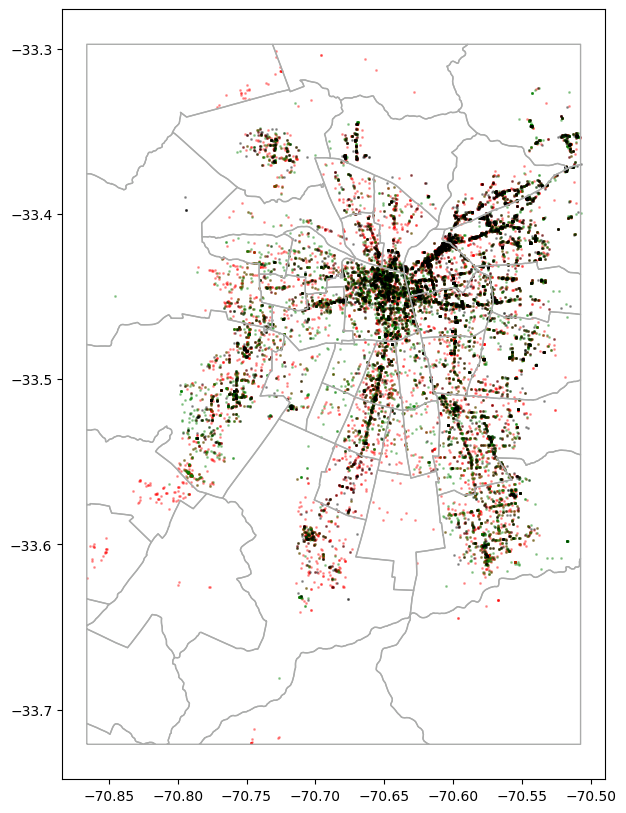

In [45]:
fig, ax = plt.subplots(figsize=(10,10))

bbox = [-70.865936,-33.720913,-70.507507,-33.297247]

zonas_en_caja = comunas_df.to_crs('epsg:4326').clip(bbox)
pedidos_en_caja = pedidos_comunas.loc[pedidos_comunas['Region']=='Región Metropolitana de Santiago'].clip(bbox)
uber_en_caja = uber_comunas.loc[uber_comunas['Region']=='Región Metropolitana de Santiago'].clip(bbox)
rappi_en_caja = rappi_comunas.loc[rappi_comunas['Region']=='Región Metropolitana de Santiago'].clip(bbox)

pedidos_en_caja.plot(markersize=5, marker=".", color="red", alpha=0.3, ax=ax)
uber_en_caja.plot(markersize=5, marker=".", color="green", alpha=0.3, ax=ax)
rappi_en_caja.plot(markersize=5, marker=".", color="black", alpha=0.3, ax=ax)
zonas_en_caja.plot(facecolor='none', edgecolor="#abacab", linewidth=1 ,ax=ax)
plt.show()

## Final

In [46]:
uber = unificados_df.set_index('code_left')['code_right']
rappi = unificados_df_2.set_index('code_left')['code_right']

In [47]:
uber_rappi_unificados = pd.merge(uber, rappi, how='outer', left_index=True, right_index=True)
# uber_rappi_unificados.reset_index(inplace=True)

In [48]:
uber_rappi_unificados

,code_right_x,code_right_y
code_left,,
100000,NaN,900033032
100001,5871e990-495d-4505-b739-d8e8f66f6fb0,NaN
100058,7705110e-20a5-537e-aa63-248d2df9fcd3,NaN
100369,NaN,900033125
100824,62423afe-13ba-41b4-8286-6b359ae32a51,NaN
...,...,...
99801,NaN,900022486
99973,052da4b3-590e-4e2f-bd67-13db6cb4ed02,NaN
99978,63fb6ec0-bdab-4e30-abc6-0fa4bff12d47,NaN


In [49]:
uber_rappi_unificados.dropna()

,code_right_x,code_right_y
code_left,,
100834,3685d6dd-b128-45ee-bf10-a619c420209c,900028564
103658,5d1cb646-7f27-4e4b-a998-9dea415cd391,900020956
105000,187d6e63-6e30-4fd2-bdfe-2e9b5cdd3c44,900018420
106604,9fb9a98a-685c-421d-8890-fc3b40f0a667,900030900
107509,8deebc33-c469-42c2-a37f-9919d4ba1ec1,900027765
...,...,...
90785,6badb842-28d6-448b-b756-ea33404c5dbc,900017312
94264,370bb155-2b57-53ff-9f91-170ede665a7d,900043886
99046,4d5318c1-78a0-421c-b148-1ccdabb4fe49,900037688


In [50]:
unificados_df

,name_left,scraper_source_left,scraper_source_right,code_left,code_right
0,[boggielato],Pedidos Ya,Uber Eats,210121,b0bcedb1-9388-49be-b9d2-e3a33f0ec149
1,"[mega, sándwich]",Pedidos Ya,Uber Eats,65153,3405ae50-c7d1-47ba-bc55-424cd367e65d
394,"[good, delivery, gourmet]",Pedidos Ya,Uber Eats,123485,9deb7ed3-4805-4b1a-b7e6-78edf766ef8b
197,"[conce, fries, &, pizza]",Pedidos Ya,Uber Eats,58069,180ecc67-6f71-49d2-a882-8f1d4ac77623
19,"[huerto, ensaladas]",Pedidos Ya,Uber Eats,178197,4dd521c1-47d8-5146-af72-07c1e6df6c3c
...,...,...,...,...,...
22428,[brens],Pedidos Ya,Uber Eats,364543,86c514cb-e364-5580-80f6-b578f84f2229
22438,"[kami, sushi, renca, poniente]",Pedidos Ya,Uber Eats,300034,bb8ef17b-c4fb-5249-8b54-36b03120278f
22471,"[pepe, pizzas, lo, espejo]",Pedidos Ya,Uber Eats,292206,5f0f824b-6300-54c0-afac-5b9726e8c23e
22479,"[kami, sushi, lo, espejo, santiago]",Pedidos Ya,Uber Eats,310447,17632b61-a466-5b2a-b6fa-a3d3e08ac871


In [51]:
# ids_pedidos = unificados_df['code_left'].tolist()
# unificados_df.set_index('code_left', inplace=True)
# unificados_df['code_3'] = unificados_df_2.set_index('code_left')['code_right']
# clusters['code_3'] = unificados_df.set_index('code_left')
# clusters['code_3'] = unificados_df_2[unificados_df_2['code_left'].isin(ids_pedidos)]
# clusters = clusters.rename(columns={'scraper_source_left', 'scraper_source_right', 'code_left', 'code_right'})

In [52]:
unificados_df[unificados_df['code_left'] == '116723']

,name_left,scraper_source_left,scraper_source_right,code_left,code_right
12488,"[sayonara, sushi, peñalolen]",Pedidos Ya,Uber Eats,116723,d61d5c97-ee1f-45e1-84bc-83f07652db81
